# Aplicação de regularização para diminuir o overfitting

<p>Note que a arquitetura da rede e os parâmetros de treinamento continuaram os mesmos. A única diferença é a aplicação da regularização, que culminou em uma melhora de 7% no desempenho da rede</p>

In [3]:
import numpy as np

In [4]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, SpatialDropout2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

Using TensorFlow backend.


# Carregando os dados

In [5]:
cifar10 = np.load("cifar10_preparado.npz")

In [6]:
x_train = cifar10['x_train']
x_val = cifar10['x_val']
x_test = cifar10['x_test']
y_train = cifar10['y_train']
y_val = cifar10['y_val']
y_test = cifar10['y_test']

# Definindo a rede neural

In [7]:
# Adição das camadas SpatialDropout2D e Dropout2D
entrada = Input(shape=(x_train.shape[1:]))
conv1 = Conv2D(32, 3, activation='relu')(entrada)
max1 = MaxPooling2D()(conv1)
conv_drop1 = SpatialDropout2D(0.025)(max1)
conv2 = Conv2D(64, 3, activation='relu')(conv_drop1)
max2 = MaxPooling2D()(conv2)
conv_drop2 = SpatialDropout2D(0.05)(max2)
conv3 = Conv2D(128, 3, activation='relu')(conv_drop2)
max3 = MaxPooling2D()(conv3)
conv_drop3 = SpatialDropout2D(0.1)(max3)
flatten = Flatten()(conv_drop3)
densa1 = Dense(512, activation='relu')(flatten)
densa_drop1 = Dropout(0.1)(densa1)
densa2 = Dense(512, activation='relu')(densa_drop1)
densa_drop2 = Dropout(0.1)(densa2)
saida = Dense(10, activation='softmax')(densa_drop2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
classificador = Model(entrada, saida)
classificador.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 6, 6, 64)          0         
__________

In [9]:
sgd = SGD(lr=0.001)
classificador.compile(optimizer = sgd, loss='categorical_crossentropy')

# Treinamento

In [10]:
from keras.utils import to_categorical

In [11]:
BATCH_SIZE = 64
NUM_EPOCHS = 150

In [12]:
model_checkpoint = ModelCheckpoint("classificador_regularizacao_epoch_{epoch:02d}.hdf5", save_best_only=True)

In [ ]:
history = classificador.fit(x=x_train, y=to_categorical(y_train, 10), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                            validation_data=(x_val, to_categorical(y_val, 10)), callbacks=[model_checkpoint])

## Curva de aprendizado

In [13]:
losses = np.array(history.history['loss'])
val_losses = np.array(history.history['val_loss'])
np.savez("curva_aprendizado_classificador_regularizacao.npz", losses=losses, val_losses=val_losses

In [15]:
losses = loss['losses']
val_losses = loss['val_losses']

In [16]:
import matplotlib.pyplot as plt

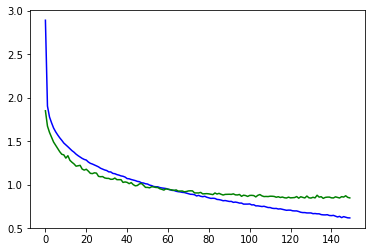

In [17]:
plt.plot(range(losses.shape[0]), losses, 'b')
plt.plot(range(val_losses.shape[0]), val_losses, 'g')

# Testando o melhor modelo

In [18]:
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Note a diferença no número de épocas necessárias! 25 contra 137
melhor_modelo = load_model("classificador_regularizacao_epoch_137.hdf5")

Instructions for updating:
Use tf.cast instead.


In [23]:
predicoes = classificador.predict(x_test)

In [24]:
predicoes.shape

(10000, 10)

In [25]:
predicoes[0]

array([7.2144647e-03, 1.7761721e-03, 8.8699963e-03, 7.4704367e-01,
       1.7953418e-03, 1.6144235e-01, 5.2196633e-02, 3.7327112e-04,
       1.8407766e-02, 8.8041130e-04], dtype=float32)

In [27]:
np.argmax(predicoes[:5], axis=1)

array([3, 8, 8, 0, 4], dtype=int64)

In [28]:
y_test[:5]

array([[3],
       [8],
       [8],
       [0],
       [6]])

In [29]:
print(classification_report(y_test, np.argmax(predicoes, axis=1)))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1000
           1       0.84      0.82      0.83      1000
           2       0.64      0.58      0.61      1000
           3       0.54      0.51      0.53      1000
           4       0.64      0.67      0.65      1000
           5       0.62      0.61      0.62      1000
           6       0.79      0.77      0.78      1000
           7       0.70      0.74      0.72      1000
           8       0.80      0.82      0.81      1000
           9       0.77      0.82      0.79      1000

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



In [30]:
print(accuracy_score(y_test, np.argmax(predicoes, axis=1)))

0.7082


In [31]:
print(f1_score(y_test, np.argmax(predicoes, axis=1), average="weighted"))

0.7072330639442627


In [32]:
matriz_confusao = confusion_matrix(y_test, np.argmax(predicoes, axis=1))
print(matriz_confusao)

[[738  19  57  19  25   5   9  14  72  42]
 [ 24 821   4   7   2   5   6   8  41  82]
 [ 64   7 577  59  92  87  52  42  12   8]
 [ 16  13  59 514  77 169  55  56  19  22]
 [ 19   3  42  62 671  33  47  95  19   9]
 [  9   7  57 158  47 614  19  72   6  11]
 [  8   7  52  66  55  24 766   7   6   9]
 [ 13   3  40  44  71  53   6 744   2  24]
 [ 71  32   9  15   3   4   4   6 816  40]
 [ 34  63   4  14   6   2  11  17  28 821]]


In [35]:
sum(matriz_confusao[2])

1000

In [36]:
total_predito = np.sum(matriz_confusao, axis=0)
print(total_predito)

[ 996  975  901  958 1049  996  975 1061 1021 1068]


In [37]:
acertos = [matriz_confusao[i][i] for i in range(10)]
acertos = np.array(acertos)
print(np.array(acertos))

[738 821 577 514 671 614 766 744 816 821]


In [38]:
acertos > total_predito

array([False, False, False, False, False, False, False, False, False,
       False])

In [39]:
erros = total_predito - acertos
print(erros)

[258 154 324 444 378 382 209 317 205 247]


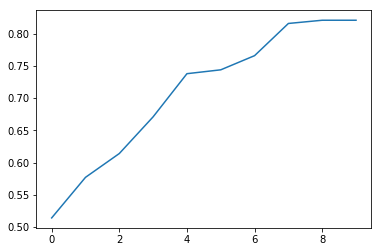

In [40]:
acuracia = acertos / 1000
plt.plot(range(10), sorted(acuracia))